## Tree Models

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, roc_auc_score,
    average_precision_score, confusion_matrix
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pd.set_option("display.max_columns", None)
df = pd.read_csv(r"C:\Users\hp\OneDrive\เอกสาร\Customer Churn\dataset\feature_engineered_data.csv")
df.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fibre_stream_pref,DSL_security_pref,has_phone,has_multipleline,tenure_bucket,avg_monthly_charge,total_addons,contract_payment,security_bins,streaming_bins,new_customers,churn
0,0,0,0,18.0,No,One year,0,Mailed check,20.10,401.85,0,0,1,0,12+,22.325000,0,One year_Mailed check,0,0,0,0
1,0,0,0,7.0,Fiber optic,Month-to-month,0,Electronic check,96.20,639.70,1,0,1,1,4-12,91.385714,2,Month-to-month_Electronic check,0,2,0,0
2,0,0,0,52.0,Fiber optic,Two year,1,Electronic check,109.30,5731.40,1,0,1,1,12+,110.219231,5,Two year_Electronic check,3+,2,0,0
3,0,1,1,46.0,No,Two year,1,Mailed check,19.95,927.10,0,0,1,0,12+,20.154348,0,Two year_Mailed check,0,0,0,0
4,1,1,0,40.0,Fiber optic,Month-to-month,0,Electronic check,101.85,4086.30,1,0,1,1,12+,102.157500,3,Month-to-month_Electronic check,1,2,0,1


## Split the data

In [13]:
X = df.drop(columns='churn', axis=1)
y = df['churn']

In [ ]:
test_size = 0.15
val_ratio = test_size/ (1 - test_size)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size,
                                                  stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio,
                                                  stratify=y_temp, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [ ]:
X_tr, X_v, X_ts, y_tr = X_train.copy(), X_val.copy(), X_test.copy(), y_train.copy()

## Preprocessing

In [ ]:
cat_cols = X_tr.select_dtypes(include=['category', 'object']).columns.tolist()
num_cols = X_tr.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

In [ ]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('rf', rf)
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [6,10,12],
    'rf__min_samples_leaf': [10, 20],
    'rf__min_samples_split': [20,50],
    'rf__max_features': ["sqrt", 0.3]
}

gs_tree = GridSearchCV(pipe, param_grid, cv=cv, scoring='average_precision', n_jobs=-1, verbose=1)
gs_tree.fit(X_tr, y_tr)

In [ ]:
print("RF best params:", gs_tree.best_params_)

In [ ]:

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for scoring in ['f1', 'average_precision', 'roc_auc']:
  train_sizes, train_score, val_score = learning_curve(pipe, X, y, cv=cv,
                                                      scoring=scoring,
                                                      train_sizes=np.linspace(0.1, 1.0, 5),
                                                      n_jobs=-1)

  train_mean = np.mean(train_score, axis=1)
  val_mean = np.mean(val_score, axis=1)

  plt.plot(train_sizes, train_mean, label=f"train {scoring}")
  plt.plot(train_sizes, val_mean, label=f"validation {scoring}")
  plt.legend()
  plt.xlabel("Training Samples")
  plt.ylabel(scoring)
  plt.title("Learning Curve")

  plt.fill_between(train_sizes, train_mean - np.std(train_score,1), train_mean + np.std(train_score, 1), alpha=0.4)
  plt.fill_between(train_sizes, val_mean - np.std(val_score, 1), val_mean + np.std(val_score, 1), alpha=0.4)
  plt.legend()
  plt.show()

In [ ]:
print("RF best score:", gs_tree.best_score_)

In [ ]:
best_est_rf = gs_tree.best_estimator_

y_val_pred = best_est_rf.predict(X_v)
y_val_prob = best_est_rf.predict_proba(X_v)[:, 1]

print("Classification Report of RF on val:\n", classification_report(y_val, y_val_pred))

In [ ]:
print("RF Average precsion:", average_precision_score(y_val, y_val_prob))
print("RF ROC-AUC score:", roc_auc_score(y_val, y_val_prob))

## Threshold Tuning

In [ ]:
from sklearn.metrics import precision_recall_curve

prec_rf, rec_rf, thresh_rf = precision_recall_curve(y_val, y_val_prob)

f1_rf = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-6)
best_idx = f1_rf.argmax()
best_thresh_rf = thresh_rf[best_idx]

print("Best threshold taken using precision-recall curve:", best_thresh_rf)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(prec_rf, rec_rf)
plt.xlabel("Precision")
plt.ylabel("recall")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(thresh_rf, f1_rf[:-1])
plt.axvline(best_thresh_rf, linestyle='--', color='red', label='Best finded threshold')
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold-F1 with Best threshold")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
y_val_pred = (y_val_prob >= best_thresh_rf).astype(int)
print("Classification Report on Threshold tuning:\n\n", classification_report(y_val, y_val_pred))

Switched from logistic regression to tree models. The objective of switching was to improve the modelling as tree models are better in capturing more non-linear patterns. First took the Random Forest with GridSearchCV to fit the model with hyperparamter tuning using different folds. Used the One Hot Encoder to encode the categorical features and the metrics showed slight different from Logitsic Regression. When looking in learning curve, the overfitting can actually seen. The metrics got from the model predict and from threshold tuning was just very slight improvement from LR. The Random Forest didn't perform as expected.

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipe
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
smote_rf = SMOTE(random_state=42)

preprocess_enc = ColumnTransformer(
    transformers= [
     ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     cat_cols),
    ('num', 'passthrough', num_cols)
])

cat_idx = list(range(len(cat_cols)))

pipe_en = ImbPipe([
    ('preproces', preprocess_enc),
    ('smotenc', SMOTENC(categorical_features=cat_idx, random_state=42)),
     ('rf', RandomForestClassifier(random_state=42))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:

for scoring in ['f1', 'average_precision', 'roc_auc']:
  train_sizes, train_scores, val_scores = learning_curve(pipe_en, X, y,
                                                       train_sizes=np.linspace(0.1, 1.0, 5),
                                                       scoring=scoring, n_jobs=-1,
                                                       cv=cv)
  train_mean, val_mean = np.mean(train_scores, axis=1), np.mean(val_scores, axis=1)

  plt.plot(train_sizes, train_mean, label=f'SMOTE train {scoring}')
  plt.plot(train_sizes, val_mean, label=f'SMOTE validation {scoring}')
  plt.xlabel("Training sample")
  plt.ylabel(scoring)

  plt.fill_between(train_sizes, train_mean - np.std(train_scores, 1), train_mean + np.std(train_scores, 1), alpha=0.3)
  plt.fill_between(train_sizes, val_mean - np.std(val_scores, 1), val_mean + np.std(val_scores, 1), alpha=0.3)

  plt.legend()
  plt.title(f"Leaning curve with scoring {scoring}")
  plt.grid(True)
  plt.show()

### Baseline vs class weight vs SMOTE

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

smote = SMOTE(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_base = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

pipe_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

pipe_sm = ImbPipe([
    ('pre', preprocess),
    ('smote', smote),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])



probs_base = cross_val_predict(pipe_base, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
probs_weight = cross_val_predict(pipe_weight, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
probs_sm = cross_val_predict(pipe_sm, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

plt.figure(figsize=(6,4))
for name, pipe in [('base', pipe_base), ('class_weight', pipe_weight), ('smote', pipe_sm)]:
  probs = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:, 1]
  prec, rec, _ = precision_recall_curve(y, probs)
  plt.plot(prec, rec, label=name)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision vs Recall")
plt.legend()
plt.show()

In [ ]:
def plot_pr(y_true, y_pred, label, color):
  prec, rec, thresh = precision_recall_curve(y_true, y_pred)
  ap = average_precision_score(y_true, y_pred)
  plt.plot(rec, prec, label=f'{label} AP:{ap:.2f}', color=color)
  plt.hlines(y_true.mean(), 0, 1, colors='lightgray', linestyles='dashed', label='Baseline (pos rate)')

  f1 = 2 * prec * rec / (prec + rec + 1e-12)
  best_idx = np.argmax(f1[:-1])
  plt.scatter(rec[best_idx], prec[best_idx], marker='o', color=color, s=60)
  plt.text(rec[best_idx], prec[best_idx], f"thr=   {thresh[best_idx]:.2f}\n\n F1={f1[best_idx]}", fontsize=10)

plt.figure(figsize=(8,6))
plot_pr(y, probs_base, label='baseline', color='C0')
plot_pr(y, probs_weight, label='Class weight', color='C1')
plot_pr(y, probs_sm, label="SMOTE", color='C2')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
tr_idx, val_idx = next(cv.split(X, y))
X_tr_fold, y_tr_fold = X.iloc[tr_idx], y.iloc[tr_idx]


from sklearn.base import clone

pre = clone(preprocess)
X_tr_pre = pre.fit_transform(X_tr_fold)
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(X_tr_pre, y_tr_fold)

print("Before SMOTE:", np.bincount(y_tr_fold))
print("After SMOTE:", np.bincount(y_sm))

From the plots and checks the sampling technique SMOTE don't just make the tradeoff better. All three remains almost same with some deviations in some regions. So first keeping class weight balanced RF model to perform the modelling and prediction.

In [ ]:


pipe_rf = ImbPipe([
    ('preprocess', preprocess),
    ('smote', smote),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [6,10,12],
    'rf__min_samples_leaf': [5,10, 20,50],
    'rf__min_samples_split': [10,20,30,50],
    'rf__max_features': ["sqrt", 0.3, 0.5]
}

cv_sm_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_sm_rf = GridSearchCV(pipe_rf, param_grid=param_grid, cv=cv_sm_rf,
                          scoring='average_precision', n_jobs=-1)

grid_sm_rf.fit(X_tr, y_tr)

In [ ]:
best_est_sm_rf = grid_sm_rf.best_estimator_

print("Best estimator score of rf (SMOTE):", grid_sm_rf.best_score_)

In [ ]:
y_val_predrf_sm = best_est_sm_rf.predict(X_v)
y_val_probrf_sm = best_est_sm_rf.predict_proba(X_v)[:, 1]

print("Classification Report on rf (SMOTE):\n", classification_report(y_val, y_val_predrf_sm))

In [ ]:
prec_sm_rf, rec_sm_rf, thresh_sm_rf = precision_recall_curve(y_val, y_val_probrf_sm)

f1_sm_rf = 2 * prec_sm_rf * rec_sm_rf / (prec_sm_rf + rec_sm_rf)
f1_sm_rf = np.nan_to_num(f1_sm_rf)
best_idx_sm = np.argmax(f1_sm_rf[:-1])
best_thr_rf = thresh_sm_rf[best_idx_sm]

print("Best found threshold:", best_thr_rf)

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(prec_sm_rf, rec_sm_rf)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision vs Recall (SMOTE)")
plt.show()

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(thresh_sm_rf, f1_sm_rf[:-1])
plt.axvline(best_thr_rf, linestyle='--', color='red', label='Best thresholf found')
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Threshold vs F1 (Best threshold point)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
y_val_pred_rf = (y_val_probrf_sm >= best_thr_rf).astype(int)
print("Classification Report on best threshold:\n\n", classification_report(y_val, y_val_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))

From the SMOTE technique as to make the minority class now ignores the problem of imbalance. When compared the baseline model vs balanced model vs the smote integrated model there doesn't saw any impact. From the plot of the compared techniques, it was clear that these techniques were found same impact. The problem was not with the imbalance. With the SMOTE performed GridSearchCV for hyperparameter tuning and threshhold tuning, the model doesn't performed better as same results compared to baseline RandomForest.

## randomized Search CV

In [ ]:
from sklearn.metrics import precision_recall_curve


rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipe = Pipeline([
    ('preprocess', preprocess),
    ('rf', rf)
])

param_dist = {
    'rf__n_estimators': [200, 500, 800],
    'rf__max_depth': [4,8,12,16, None],
    'rf__min_samples_split': [5,10,15,20],
    'rf__min_samples_leaf': [2,5,10,12],
    'rf__max_features': ['sqrt', 0.3, 0.5]
}

rs = RandomizedSearchCV(pipe, param_distributions=param_dist,
                        n_iter=20, scoring='average_precision',
                        cv=5, random_state=42, n_jobs=-1)

rs.fit(X_tr, y_tr)

In [ ]:
print("Best parameters:", rs.best_params_)
print("Best score:", rs.best_score_)


best_est_rs = rs.best_estimator_

In [ ]:
from sklearn.metrics import precision_recall_curve

y_val_pred_rs = best_est_rs.predict(X_v)
y_val_prob_rs = best_est_rs.predict_proba(X_v)[:, 1]

prec_res, rec_res, thr_rs = precision_recall_curve(y_val, y_val_prob_rs)
idx = np.where(rec_res >= 0.7)[0][-1]
best_thr = thr_rs[idx]

print("Chosen threshold:", best_thr)


In [ ]:
y_val_prob = (y_val_prob_rs >= best_thr).astype(int)
print("Confusion matrix:\n\n", confusion_matrix(y_val, y_val_prob))
print("\n\nClassification Report:\n\n", classification_report(y_val, y_val_pred_rs))

In [ ]:
prec, rec, thresh  = precision_recall_curve(y_val, y_val_prob_rs)

plt.figure(figsize=(8,6))
plt.plot(prec, rec)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision vs Recall")
plt.show()

In [ ]:
f1 = 2 * prec * rec / (prec + rec + 1e-6)
best_idx = np.argmax(f1[:-1])
best_thrssh = thresh[best_idx]
best_f1 = f1[:-1][best_idx]
print("Best threshold:", best_thrssh, "Best F1:", best_f1)

In [ ]:
y_val_pred = (y_val_prob_rs >= best_thrssh).astype(int)
print("Classification report on threshold tunining from PR-curve:", classification_report(y_val, y_val_pred))

## Calibration

In [ ]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


cal_rf = CalibratedClassifierCV(best_est_rs, cv=5, method='isotonic')
cal_rf.fit(X_tr, y_tr)


In [ ]:
predict_calprob = cal_rf.predict_proba(X_v)[:, 1]

print("PR-AUC:", average_precision_score(y_val, predict_calprob))
print("Uncalibrated brier score:", brier_score_loss(y_val, y_val_prob_rs))
print("Calibrated Brier score:", brier_score_loss(y_val, predict_calprob))

### Calibration curve

In [ ]:
true_pred_rf, prob_pred_rf = calibration_curve(y_val, predict_calprob, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(true_pred_rf, prob_pred_rf, marker='o')
plt.xlabel("True Prediction")
plt.ylabel("Predicted Probability")
plt.title("True Prediction vs Predicted Probabaility (Calibration)")
plt.grid(True)
plt.show()

In [ ]:
prec_rf, rec_rf, thresh_rf = precision_recall_curve(y_val, predict_calprob)

f1_rf = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-8)
best_idx_rf = np.argmax(f1_rf[:-1])
best_thrsh = thresh_rf[best_idx_rf]

print("Best Threshold using calibration:", best_thrsh)

In [ ]:
y_val_pred_rf = (predict_calprob >= best_thrsh).astype(int)
print("Classification Report (calibration):\n\n", classification_report(y_val, y_val_pred_rf))

From randomized search cv, the model slightly good at catching churners, but too the improvement in F1 was not impactful. The RandomForest are not performing as expected. Furthur feature engineering or use of boosting models is preffered.

## Furthur Feature engineering and Analysis

In [ ]:
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Imbpipe
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Imbpipe

In [14]:
X_new = X

In [15]:
X_new['spend_per_addon'] = X_new['MonthlyCharges'] / (1 + X_new['total_addons'])

In [ ]:
pd.set_option('display.max_columns', None)
X_new.head()

In [ ]:
test_size=0.15
val_ratio = test_size / (1-test_size)

X_temp, X_test_new, y_temp, y_test_new = train_test_split(X_new, y, test_size=test_size,
                                                          stratify=y, random_state=42)

X_tr_new, X_val_new, y_tr_new, y_val_new = train_test_split(X_temp, y_temp,
                                                            test_size=val_ratio,
                                                            stratify=y_temp,
                                                            random_state=42)

X_tr_new.shape, X_val_new.shape, y_tr_new.shape, y_val_new.shape, X_test_new.shape, y_test_new.shape

In [ ]:
num_cols_new = X_tr_new.select_dtypes(include='number').columns.tolist()
cat_cols_new = X_tr_new.select_dtypes(include=['category', 'object']).columns.tolist()

In [ ]:
for col in num_cols_new:
  auc = roc_auc_score(y_tr_new, X_tr_new[col])
  print(f"Numeric col - {col} ROC-AUC: {auc:.3f}")

In [ ]:
ohe = OneHotEncoder(drop=None, handle_unknown='ignore', sparse_output=False)
X_cat_ohe = ohe.fit_transform(X_new[cat_cols_new])

selected_ohe_col = []
for i, col in enumerate(ohe.get_feature_names_out(cat_cols_new)):
  auc = roc_auc_score(y, X_cat_ohe[:, i])
  if auc > 0.6:
    selected_ohe_col.append(col)
  print(f"Categrocial col {col} (OHE transformed)  - ROC AUC Score : {auc:.2f}")

### Feature interactions

In [ ]:
def create_flag(df, name):

  orig, cat = name.split('_', 1)
  safe_cat = cat

  if orig in df.columns:
    new_col = f"flag_{orig}__{safe_cat.replace(' ', '_')}"
    df[new_col] = (df[orig].astype(str) == safe_cat).astype(int)
    return new_col

  if orig == 'contract' or orig == 'contract_payment' or '__' in name:

    parts = name.split('_')

    if name.startswith('contract_payment'):
      _, _, contract_val, payment_val = parts[0], parts[1], parts[2], ' '.join(parts[3:])
      new_col = f"flag_contract_{contract_val.replace(' ', '_')}__payment_{payment_val.replace(' ', '_')}"
      df[new_col] = ((df['Contract'].astype(str) == contract_val) & (df['PaymentMethod'].astype(str) == payment_val)).astype(int)

      return new_col

  return None

In [ ]:
created_flags = []

for name in selected_ohe_col:
  flag = create_flag(X_new, name)

  if flag:
    created_flags.append(flag)


X_new['flag_short_tenure'] = (X_new['tenure'] <= 3).astype(int)

if 'flag_Contract_Month-to-month' in X_new.columns:
  X_new['flag_short_tenure_month-month'] = (X_new['flag_short_tenure'] & X_new['flag_Contract_Month-to-month']).astype(int)
  created_flags.append('flag_short_tenure_month')

In [ ]:
X_new = X_new.drop(columns=['new_customers', 'TotalCharges', 'contract_payment'], axis=1)
X_new.head()

In [ ]:
num_cols_new = X_tr_new.select_dtypes(include='number').columns.tolist()
cat_cols_new = X_tr_new.select_dtypes(exclude='number').columns.tolist()

In [ ]:
for col in num_cols_new:
  auc = roc_auc_score(y_tr_new, X_tr_new[col])
  print(f"Numeric col - {col} ROC-AUC: {auc:.3f}")

In [ ]:
# smote = SMOTE(random_state=42)
preprocess_new = ColumnTransformer([
    ('num', 'passthrough', num_cols_new)
])

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipe_new = Imbpipe([
    ('preprocess', preprocess_new),
    ('smote', smote),
    ('rf', rf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:

for scoring in ['f1', 'average_precision', 'roc_auc']:
  train_sizes, train_scores, val_scores = learning_curve(pipe_new, X_tr_new, y_tr_new,
                                                       train_sizes=np.linspace(0.1, 1.0, 5),
                                                       scoring=scoring, n_jobs=1,
                                                       cv=cv, verbose=1)
  train_mean, val_mean = np.mean(train_scores, axis=1), np.mean(val_scores, axis=1)

  plt.plot(train_sizes, train_mean, label=f'train {scoring}')
  plt.plot(train_sizes, val_mean, label=f'validation {scoring}')

  plt.fill_between(train_sizes, train_mean - np.std(train_scores, 1), train_mean + np.std(train_scores, 1), alpha=0.3)
  plt.fill_between(train_sizes, val_mean - np.std(val_scores, 1), val_mean + np.std(val_scores, 1), alpha=0.3)

  plt.xlabel("Training sample")
  plt.ylabel(scoring)
  plt.legend()
  plt.title(f"Leaning curve with scoring {scoring}")
  plt.grid(True)
  plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_new, X_tr_new, y_tr_new, cv=cv,
                         scoring='average_precision',
                         n_jobs=-1)
print("RF CV AP:", scores.mean(), "+-", scores.std())

When taking roc-auc score on each features of numeric and categorical, there are reduntant features like `SeniorCitizen`, `Partner` and `avg_monthly_charge`, `new_customers`, `spend_per_addon` has more predictive power. In categorical features, `Electronic check` interaction feature, `Fibre Optic` interaction feature have more predictive power. As from roc_auc score it can't be finalized as these are predictive but may have useful predictive power. When taking the interaction features that seems predictive is taken with use of OHE to check for improvements.

# LightGBM

In [81]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, average_precision_score,
    f1_score, roc_auc_score, confusion_matrix
)
import shap
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_new = X_new.drop(columns='avg_monthly_charge', axis=1)

In [85]:
num_cols_lgb = X_new.select_dtypes(include='number').columns.tolist()
cat_cols_lgb = X_new.select_dtypes(exclude='number').columns.tolist()

In [86]:
test_size=0.15
val_ratio = test_size / (1-test_size)

X_temp, X_test_new, y_temp, y_test_new = train_test_split(X_new, y, test_size=test_size,
                                                          stratify=y, random_state=42)

X_tr_new, X_val_new, y_tr_new, y_val_new = train_test_split(X_temp, y_temp,
                                                            test_size=val_ratio,
                                                            stratify=y_temp,
                                                            random_state=42)

X_tr_new.shape, X_val_new.shape, X_test_new.shape,  y_tr_new.shape, y_val_new.shape, y_test_new.shape

((4929, 21), (1057, 21), (1057, 21), (4929,), (1057,), (1057,))

In [87]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_new))
oof_per_folds = []

models = []

fold_metrics = []
best_iters_lgb = []


scale_pos_weight = (y == 0).sum() / (y == 1).sum()

base_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": 'auc',
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_child_samples": 30,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
    "scale_pos_weight": scale_pos_weight
}

In [88]:
for fold, (tr_idx, vl_idx) in enumerate(skf.split(X_new, y)):

  print(f"Fold {fold+1}")

  X_tr, X_val = X_new.iloc[tr_idx], X_new.iloc[vl_idx]
  y_tr, y_val = y.iloc[tr_idx], y.iloc[vl_idx]

  lgb_classif = lgb.LGBMClassifier(**base_params, n_estimators=10000, random_state=42)

  lgb_classif.fit(
      X_tr, y_tr,
      eval_set=[(X_val, y_val)],
      eval_metric='auc',
      categorical_feature=cat_cols_lgb,
      callbacks=[early_stopping(stopping_rounds=100), log_evaluation(0)]
  )

  val_probs = lgb_classif.predict_proba(X_val, num_iteration=lgb_classif.best_iteration_)[:, 1]
  oof_preds[vl_idx] = val_probs
  oof_per_folds.append(val_probs)
  models.append(lgb_classif)
  best_iters_lgb.append(lgb_classif.best_iteration_)

  val_auc = roc_auc_score(y_val, val_probs)
  val_ap = average_precision_score(y_val, val_probs)

  print(f"Fold {fold+1}, AUC: {val_auc:.4f}, AP: {val_ap:.4f}")
  fold_metrics.append({"fold": fold + 1, "auc": val_auc, "AP": val_ap})


Fold 1
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.845571
Fold 1, AUC: 0.8456, AP: 0.6574
Fold 2
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM]

In [89]:
print("=======OOF Evaluation=======")
oof_auc = roc_auc_score(y, oof_preds)
oof_ap = average_precision_score(y, oof_preds)

print(f"OOF AUC: {oof_auc:.4f}")
print(f"OOF AP: {oof_ap:.4f}")

=======OOF Evaluation=======
OOF AUC: 0.8424
OOF AP: 0.6455


## PR-Curve and Threshold tuning

In [90]:
prec_lg, rec_lg, thresh_lg = precision_recall_curve(y, oof_preds)

f1_lg = 2 * prec_lg[:-1] * rec_lg[:-1] / (prec_lg[:-1] + rec_lg[:-1] + 1e-6)
best_idx = np.nanargmax(f1_lg)
best_thresh_lg = thresh_lg[best_idx]

print("Best threshold for LGBM:", best_thresh_lg)

Best threshold for LGBM: 0.521052618626263


## Precision-Recall curve

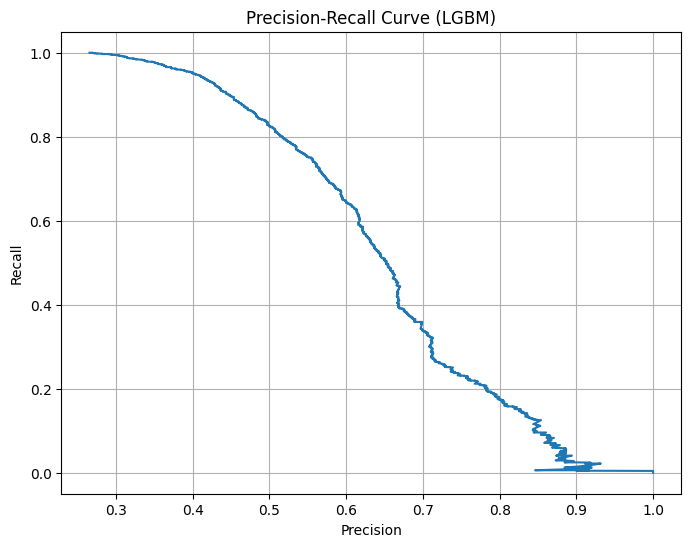

In [91]:
plt.figure(figsize=(8,6))
plt.plot(prec_lg, rec_lg)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve (LGBM)")
plt.grid(True)
plt.show()

## Classification Report and Confusion metrics

In [92]:
preds = np.mean([m.predict_proba(X_test_new)[:,1]  for m in models], axis=0)
y_preds_lg = (preds >= best_thresh_lg).astype(int)

print("Classification Report:\n\n", classification_report(y_test_new, y_preds_lg))
print("\nROC-AUC:", roc_auc_score(y_test_new, preds), "AP:", average_precision_score(y_test_new, preds))

Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.80      0.86       777
           1       0.59      0.82      0.69       280

    accuracy                           0.80      1057
   macro avg       0.76      0.81      0.77      1057
weighted avg       0.84      0.80      0.81      1057


ROC-AUC: 0.890391156462585 AP: 0.7149878208345358


In [93]:
print("Confusion Matrix:\n", confusion_matrix(y_test_new, y_preds_lg))

Confusion Matrix:
 [[618 159]
 [ 50 230]]


## Calibrated

In [94]:
from sklearn.calibration import  CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

final_est_lgb = lgb.LGBMClassifier(**base_params, n_estimators=int(np.mean(best_iters_lgb)))
cal = CalibratedClassifierCV(final_est_lgb, cv=skf, method='isotonic')
cal.fit(X_tr_new, y_tr_new)
cal_val_probs = cal.predict_proba(X_val_new)[:, 1]

print("Brier Score:", brier_score_loss(y_val_new, cal_val_probs))

[LightGBM] [Info] Number of positive: 1047, number of negative: 2896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 3943, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265534 -> initscore=-1.017402
[LightGBM] [Info] Start training from score -1.017402
[LightGBM] [Info] Number of positive: 1046, number of negative: 2897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 3943, number of used features: 21
[LightGBM] [Info] [binary:

In [95]:
y_prob_uncal = models[-1].predict_proba(X_val_new)[:, 1]

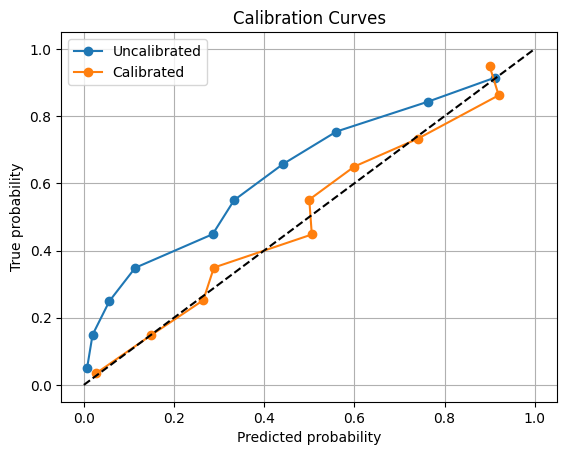

In [96]:
for prob, label in [(y_prob_uncal, "Uncalibrated"), (cal_val_probs, "Calibrated")]:
  pred, true = calibration_curve(y_val_new, prob, n_bins=10)

  plt.plot(pred, true, marker='o', label=label)

plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curves")
plt.grid(True)
plt.legend()
plt.show()

## SHAP Explainer

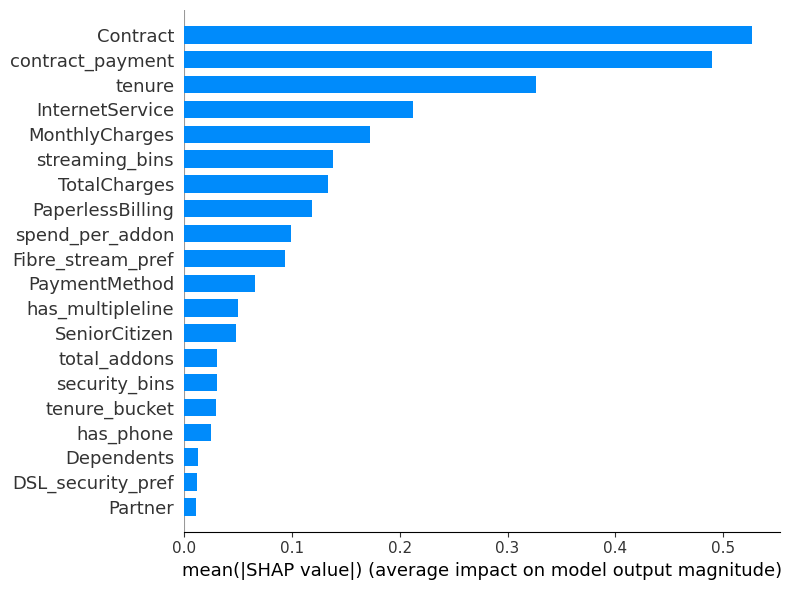

In [97]:
explainer =shap.TreeExplainer(models[-1])
sample_X = X_new.sample(2000, random_state=42)

shap_vals = explainer.shap_values(sample_X)

shap.summary_plot(shap_vals, sample_X, plot_type="bar", plot_size=(8,6))

## OPTUNA

Hyperparameter tuning strategy.

In [31]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):

  param = {
      "objective": "binary",
      "boosting_type": "gbdt",
      "n_jobs": -1,
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
      "num_leaves": trial.suggest_int("num_leaves", 15, 30),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
      "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
      "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
      "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
      "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
      "scale_pos_weight": scale_pos_weight
  }

  clf = lgb.LGBMClassifier(**param, n_estimators=200, random_state=42)
  score = cross_val_score(clf, X_new, y, cv=skf, scoring='average_precision', n_jobs=-1).mean()
  return score

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, n_jobs=1)
best_parm_lgb = study.best_params
print("Best param:", best_parm_lgb)

[I 2025-10-03 10:26:14,449] A new study created in memory with name: no-name-c4a5e0b3-f590-4c3a-917d-d794f4ae30e1
[I 2025-10-03 10:26:20,268] Trial 0 finished with value: 0.6433398310358578 and parameters: {'learning_rate': 0.06434958888641733, 'num_leaves': 27, 'min_child_samples': 30, 'feature_fraction': 0.5627596065115859, 'bagging_fraction': 0.8767183283087439, 'bagging_freq': 2, 'reg_lambda': 0.01889325378591746}. Best is trial 0 with value: 0.6433398310358578.
[I 2025-10-03 10:26:24,762] Trial 1 finished with value: 0.656325524279092 and parameters: {'learning_rate': 0.02682699980240627, 'num_leaves': 21, 'min_child_samples': 28, 'feature_fraction': 0.9061087175903789, 'bagging_fraction': 0.5842524144508525, 'bagging_freq': 10, 'reg_lambda': 0.011793788279207781}. Best is trial 1 with value: 0.656325524279092.
[I 2025-10-03 10:26:29,598] Trial 2 finished with value: 0.6114461594236025 and parameters: {'learning_rate': 0.18787670288717956, 'num_leaves': 27, 'min_child_samples': 6,

Best param: {'learning_rate': 0.022912694485513987, 'num_leaves': 24, 'min_child_samples': 30, 'feature_fraction': 0.5749557122007624, 'bagging_fraction': 0.7866630605443999, 'bagging_freq': 3, 'reg_lambda': 3.9035995100621217}


## Stabilize model with optuna best parameters

In [33]:
best_parm_lgb['n_jobs'] = -1
best_parm_lgb['random_state'] = 42
best_parm_lgb['objective'] = 'binary'
best_parm_lgb['scale_pos_weight'] = scale_pos_weight
best_parm_lgb

{'learning_rate': 0.022912694485513987,
 'num_leaves': 24,
 'min_child_samples': 30,
 'feature_fraction': 0.5749557122007624,
 'bagging_fraction': 0.7866630605443999,
 'bagging_freq': 3,
 'reg_lambda': 3.9035995100621217,
 'n_jobs': -1,
 'random_state': 42,
 'objective': 'binary',
 'scale_pos_weight': np.float64(2.7683253076511503)}

In [34]:
oof_preds_opt = np.zeros(len(X_new))
oof_per_folds_opt = []

models_opt = []

fold_metrics_opt = []
best_iters = []


for fold, (tr_idx, vl_idx) in enumerate(skf.split(X_new, y)):

  print(f"Fold {fold+1}")

  X_tr, X_val = X_new.iloc[tr_idx], X_new.iloc[vl_idx]
  y_tr, y_val = y.iloc[tr_idx], y.iloc[vl_idx]

  lgb_classif_opt = lgb.LGBMClassifier(**best_parm_lgb, n_estimators=10000)

  lgb_classif_opt.fit(
      X_tr, y_tr,
      eval_set=[(X_val, y_val)],
      eval_metric='auc',
      categorical_feature=cat_cols_lgb,
      callbacks=[early_stopping(stopping_rounds=100), log_evaluation(0)]
  )

  val_probs = lgb_classif.predict_proba(X_val, num_iteration=lgb_classif.best_iteration_)[:, 1]
  oof_preds_opt[vl_idx] = val_probs
  oof_per_folds_opt.append(val_probs)
  models_opt.append(lgb_classif)
  best_iters.append(lgb_classif.best_iteration_)

  val_auc = roc_auc_score(y_val, val_probs)
  val_ap = average_precision_score(y_val, val_probs)

  print(f"Fold {fold+1}, AUC: {val_auc:.4f}, AP: {val_ap:.4f}")
  fold_metrics_opt.append({"fold": fold + 1, "auc": val_auc, "AP": val_ap})


Fold 1
[LightGBM] [Warning] feature_fraction is set=0.5749557122007624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749557122007624
[LightGBM] [Warning] bagging_fraction is set=0.7866630605443999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7866630605443999
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5749557122007624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749557122007624
[LightGBM] [Warning] bagging_fraction is set=0.7866630605443999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7866630605443999
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
Yo

In [35]:
prec_opt, rec_opt, thrsh_opt = precision_recall_curve(y, oof_preds_opt)

f1s_opt = 2 * prec_opt[:-1] * rec_opt[:-1] / (rec_opt[:-1] + prec_opt[:-1] + 1e-6)
best_idx_opt = np.nanargmax(f1s_opt)
best_thresh_opt = thrsh_opt[best_idx_opt]

print("Best F1:", f1s_opt[best_idx_opt], "Best threshold:", best_thresh_opt)

Best F1: 0.666974746316006 Best threshold: 0.45993205638501244


In [36]:
preds_opt = np.mean([m.predict_proba(X_test_new)[:,1]  for m in models_opt], axis=0)
y_preds_opt = (preds_opt >= best_thresh_opt).astype(int)

print("\n\nClassification Report of Optuna:\n\n", classification_report(y_test_new, y_preds_opt))
print("\nROC-AUC:", roc_auc_score(y_test_new, preds_opt), "AP:", average_precision_score(y_test_new, preds_opt))
print("\n Confusion matrix:\n", confusion_matrix(y_test_new, y_preds_opt))



Classification Report of Optuna:

               precision    recall  f1-score   support

           0       0.92      0.81      0.86       777
           1       0.61      0.81      0.69       280

    accuracy                           0.81      1057
   macro avg       0.76      0.81      0.78      1057
weighted avg       0.84      0.81      0.82      1057


ROC-AUC: 0.8771993932708219 AP: 0.6845926256846501

 Confusion matrix:
 [[631 146]
 [ 54 226]]


## Final Estimation

In [70]:
X_tr_all, y_tr_all = pd.concat([X_tr_new, X_val_new]), pd.concat([y_tr_new, y_val_new])
cat_features = X_tr_all.select_dtypes(exclude='number').columns.tolist()

In [71]:
final_model = lgb.LGBMClassifier(**base_params, n_estimators=int(np.mean(best_iters_lgb)),
                                 random_state=42)

final_model.fit(X_tr_all, y_tr_all,
                categorical_feature=cat_features,
                eval_metric='auc')

[LightGBM] [Info] Number of positive: 1589, number of negative: 4397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 5986, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265453 -> initscore=-1.017818
[LightGBM] [Info] Start training from score -1.017818


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,47
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,30


In [72]:
test_probs = final_model.predict_proba(X_test_new, num_iteration=final_model.best_iteration_)[:, 1]

prec, rec, thresh = precision_recall_curve(y_test_new, test_probs)

f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.nanargmax(f1)
best_threshold = thresh[best_idx]

print("Best threshold:", best_threshold, "Best F1:", f1[best_idx])

Best threshold: 0.5334789291201277 Best F1: 0.6676602086433289


In [73]:
test_preds  =(test_probs >= best_threshold).astype(int)

print("ROC-AUC score:", roc_auc_score(y_test_new, test_probs))
print("Average Precision:", average_precision_score(y_test_new, test_probs))
print("\nClassification report:\n\n", classification_report(y_test_new, test_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_new, test_preds))

ROC-AUC score: 0.850229821658393
Average Precision: 0.6427611702198349

Classification report:

               precision    recall  f1-score   support

           0       0.92      0.79      0.85       777
           1       0.57      0.80      0.67       280

    accuracy                           0.79      1057
   macro avg       0.74      0.79      0.76      1057
weighted avg       0.83      0.79      0.80      1057


Confusion Matrix:
 [[610 167]
 [ 56 224]]


From the Random Forest, the improvements was not as greater as  expected. So by moving into LightGBM with base parameters and fitted using cv folds, the model improved. The model catched most churners with a good recall and a good range of precisoon. As the objective was catching more churners. The fiting was done with the feature interaction and also without it. So when comparing th metrics, the without interaction peformed well. The hyperparameter tuning was tuning was done using `OPTUNA`. But the performance was less compared to the classifier without Optuna. From the calibration plot, the truen probabilities was actualy very well reflected. That actually contributes a lot for business goals. The SHAP shows the more important and less important features. 

The final estimator was chosen with best iteration mean taken from best iterations list that got from the cross validation folds fiting. When the final model was predicted to the unseen data it performed as well. Slight changes in down happened but that's accepted while seeing the unseen data. The ROC-AUC  droped in a very slight manner but Average precision dropped a few beacuse of imbalance of classes. 


Future implementation: Collecting more churn data helps the model to increase its performance. The true data actually gives the valid signal and avoids the cause of noise. 

In [107]:
pd.set_option("display.max_columns", None)
X_new[cat_cols_lgb].head()

,InternetService,Contract,PaymentMethod,tenure_bucket,contract_payment,security_bins
0,No,One year,Mailed check,12+,One year_Mailed check,0
1,Fiber optic,Month-to-month,Electronic check,4-12,Month-to-month_Electronic check,0
2,Fiber optic,Two year,Electronic check,12+,Two year_Electronic check,3+
3,No,Two year,Mailed check,12+,Two year_Mailed check,0
4,Fiber optic,Month-to-month,Electronic check,12+,Month-to-month_Electronic check,1
